In [1]:
import numpy as np
import networkx as nx
from edge_fetch import edge_terrier
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from featureAnalysis import featureSelection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib
from sklearn.cluster import MiniBatchKMeans

In [2]:
##### Functions ######

##### Features ######

def getEigenVectorCentralityFeatures(graphList, numFeatures):
    # Eigen vector centrality is calculated using the sklearn function
    # The numFeatures chosen are selected based on the largest values
    # Largest values is determined by averaging the values for a node across all subjects
    # The numFeatures highest averages are used to select the features
    featureObj = featureSelection(graphList)
    X = featureObj.eigenvectorCentrality(numFeatures)
    mat = np.matrix(X, dtype = float)
    with open('outfileMat_HNU.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")
    return mat
    
def getKHOPFeatures(graphList, numFeatures):
    # Khop values are calculated using the networkx function
    # The values are calculated for 1 hop and 2 hops for each node
    # The numFeatures chosen are selected based on the highest variance values
    featureObj = featureSelection(graphList)
    X = featureObj.getKhopFeatMat1(numFeatures)
    mat = np.matrix(X, dtype = float)
    with open('outfileMat.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")
    return mat

###### Plotting #####
    
def graph2D(mat, correctLabels):
    fig = plt.figure(3, figsize=(10, 10))
    fig.suptitle("Visualization of Clustered HNU Data (dwi)", fontsize=20)
    ax = plt.Axes(fig, rect=[0, 0, .5, .5])
    z = list(correctLabels)
    N = len(mat[:,1])
    x = [mat[:,0]]
    y = [mat[:,1]]
    cmap = matplotlib.cm.get_cmap('plasma')
    normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]
    plt.scatter(x, y, color = colors)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
def graph3D(mat, correctLabels):
    fig = plt.figure(3, figsize=(10, 10))
    fig.suptitle("Visualization of Clustered HNU Data (dwi)", fontsize=20)
    ax = Axes3D(fig, rect=[0, 0, .5, .5], elev=40, azim=150)
    ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c=correctLabels, cmap = "plasma")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
def graph2DLabels(mat, labels):
    fig = plt.figure(3, figsize=(10, 10))
    ax = plt.Axes(fig, rect=[0, 0, .5, .5])
    z = list(labels)
    N = len(mat[:,1])
    x = [mat[:,0]]
    y = [mat[:,1]]
    cmap = matplotlib.cm.get_cmap('plasma')
    normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]
    plt.scatter(x, y, color = colors)
    plt.title("HBN Eigenvector Centrality - \nJHU Directory all dwi samples")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
def graph3DLabels(mat, labels):
    fig = plt.figure(4, figsize=(10, 10))
    ax = Axes3D(fig, rect=[0, 0, .5, .5], elev=40, azim=150)
    ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c=labels, cmap = "plasma")
    ax.set_title("HBN Eigenvector Centrality - \nJHU Directory all dwi samples")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
##### Clustering ######
def AffinityPropagationClustering(inputMat, dampInit = .4, dampInc = .1, preferenceInit = 0, preferenceInc = .05):
    maxDamp = 0
    maxPre = 0
    maxSil = 0
    pre = preferenceInit
    while pre < 1:
        #vary the preference value
        pre = pre + preferenceInc
        damp = dampInit
        while damp + dampInc <= .95:
            #vary the damping value
            damp = damp + dampInc
            af = AffinityPropagation(damping = damp, preference = pre, affinity="precomputed").fit(inputMat)
            cluster_centers_indices = af.cluster_centers_indices_
            labels = af.labels_
            n_clusters = len(cluster_centers_indices)
            if n_clusters <= len(inputMat) - 1:
                ss = silhouette_score(inputMat, labels)
                print('|Preference |% 1.2f' % pre, "| Damping | % 1.1f" % damp,"| Clusters | ", n_clusters, "| Silhouette | % 1.3f" % ss, "|")
            #capture max preproc and damping
                if (ss > maxSil):
                    maxDamp = damp
                    maxPre = pre
                    maxSil = ss
    print("Best Damping Value:", maxDamp, "Best Preference Value:", maxPre)
    return maxDamp, maxPre, maxSil

def MiniBatchKMeansClustering(inputMat, clustInit = 1, clustInc = 1, batchSizeInit = 40, batchSizeInc = 10):
    maxClusters = 0
    maxSize = 0
    maxSil = 0
    clust = clustInit
    while clust < (len(inputMat) * 3 / 4):
        #vary the cluster number
        batchSize = batchSizeInit
        clust = clust + clustInc
        while batchSize < len(inputMat):
            #vary the batch size
            batchSize = batchSize + batchSizeInc
            mb = MiniBatchKMeans(n_clusters = clust, batch_size = batchSize).fit(inputMat)
            cluster_centers_ = mb.cluster_centers_
            labels = mb.labels_
            ss = silhouette_score(inputMat, labels)
            print('|BatchSize |% 1.2f' %  batchSize, "| Clusters | % 1.1f" % clust, "| Silhouette | % 1.3f" % ss, "|")

            #capture best clusters and batchsize
            if (ss > maxSil):
                maxClusters = clust
                maxSize = batchSize
                maxSil = ss
    print("Best Batch Size:", maxSize, "Best Num Clusters:", maxClusters)
    return maxClusters, maxSize, maxSil

In [3]:
######  Initialize edgelist collector object ######
graph_collector = edge_terrier('/Users/paigefrank/Library/Python/3.6/bin/aws', 0, filepath='data/HNU1/ndmg_0-0-48/graphs/JHU/')
# Make a generator that yields all edgelists in filepath
filelist = graph_collector.convert_gpickle_all()
# Get a list of just the network x objects
graphList, fileList = graph_collector.getGraphs(filelist)

In [71]:
##### Output feature matrix to a file ####
numFeatures = 50
#mat = getKHOPFeatures(graphList, numFeatures)
mat = getEigenVectorCentralityFeatures(graphList, numFeatures)


Feature matrix of shape (300, 48) outputted. Run Urerf in R now.


In [72]:
##### Load Similarity Matrix from Urerf #####
matrix = open('outfileSimMat.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)

In [73]:
##### Collect Correct Labels #####
correctLabels = []
for item in fileList:
    correctLabels.append(float(item[4:11]) - 25426.0)

In [74]:
##### Graph the data if the features are less than 3 dimensions #####

if (numFeatures ==2):
    graph2D(mat, correctLabels)
    
if (numFeatures ==3):
    graph3D(mat, correctLabels)


In [75]:
#Cluster with affinity Propogation for multiple parameters
##### CLUSTER ######
print("AFFINITY PROPAGATION")
maxDamp, maxPre, maxSil = AffinityPropagationClustering(inputMat,.4,.1, 0, .05)
print("MINI BATCH K MEANS")
maxClusters, maxSize, maxSil = MiniBatchKMeansClustering(mat, 0, 30, 50, 50)

AFFINITY PROPAGATION
|Preference | 0.05 | Damping |  0.5 | Clusters |  32 | Silhouette |  0.178 |
|Preference | 0.05 | Damping |  0.6 | Clusters |  32 | Silhouette |  0.175 |
|Preference | 0.05 | Damping |  0.7 | Clusters |  32 | Silhouette |  0.181 |
|Preference | 0.05 | Damping |  0.8 | Clusters |  30 | Silhouette |  0.177 |
|Preference | 0.05 | Damping |  0.9 | Clusters |  30 | Silhouette |  0.172 |
|Preference | 0.10 | Damping |  0.5 | Clusters |  32 | Silhouette |  0.181 |
|Preference | 0.10 | Damping |  0.6 | Clusters |  33 | Silhouette |  0.176 |
|Preference | 0.10 | Damping |  0.7 | Clusters |  32 | Silhouette |  0.181 |
|Preference | 0.10 | Damping |  0.8 | Clusters |  31 | Silhouette |  0.175 |
|Preference | 0.10 | Damping |  0.9 | Clusters |  31 | Silhouette |  0.175 |
|Preference | 0.15 | Damping |  0.5 | Clusters |  33 | Silhouette |  0.183 |
|Preference | 0.15 | Damping |  0.6 | Clusters |  33 | Silhouette |  0.176 |
|Preference | 0.15 | Damping |  0.7 | Clusters |  33 | 

|BatchSize | 200.00 | Clusters |  60.0 | Silhouette |  0.249 |
|BatchSize | 250.00 | Clusters |  60.0 | Silhouette |  0.247 |
|BatchSize | 300.00 | Clusters |  60.0 | Silhouette |  0.242 |
|BatchSize | 100.00 | Clusters |  90.0 | Silhouette |  0.197 |
|BatchSize | 150.00 | Clusters |  90.0 | Silhouette |  0.227 |
|BatchSize | 200.00 | Clusters |  90.0 | Silhouette |  0.227 |
|BatchSize | 250.00 | Clusters |  90.0 | Silhouette |  0.223 |
|BatchSize | 300.00 | Clusters |  90.0 | Silhouette |  0.202 |
|BatchSize | 100.00 | Clusters |  120.0 | Silhouette |  0.185 |
|BatchSize | 150.00 | Clusters |  120.0 | Silhouette |  0.184 |
|BatchSize | 200.00 | Clusters |  120.0 | Silhouette |  0.200 |
|BatchSize | 250.00 | Clusters |  120.0 | Silhouette |  0.185 |
|BatchSize | 300.00 | Clusters |  120.0 | Silhouette |  0.188 |
|BatchSize | 100.00 | Clusters |  150.0 | Silhouette |  0.159 |
|BatchSize | 150.00 | Clusters |  150.0 | Silhouette |  0.156 |
|BatchSize | 200.00 | Clusters |  150.0 | Silhou

In [76]:
##### isolate best clustering output and create a sorted similarity matrix ####

# cluster using the best affinity propagation output
af = AffinityPropagation(damping = maxDamp, preference = maxPre,affinity="precomputed").fit(inputMat)
cluster_centers_indices = af.cluster_centers_indices_
labels_best_af = af.labels_
n_clusters_af = len(cluster_centers_indices)


# cluster using the best mini batch k means output
mb = MiniBatchKMeans(n_clusters= maxClusters, batch_size = maxSize).fit(mat)
cluster_centers_ = mb.cluster_centers_
labels_best_mb = mb.labels_
n_clusters_mb = len(cluster_centers_)


#create a dictionary of labels and nodes
nodeDict = dict(enumerate(labels_best_af))
#sort the nodes so that they are grouped by cluster label
s = sorted(nodeDict, key=nodeDict.get)

#create a sorted similarity matrix
sortedSimMat = np.empty((len(s), len(s)))
for i in range(0, len(s)):
    node = s[i]
    for j in range(0,len(s)):
        node2 = s[j]
        sortedSimMat[i][j] = inputMat[node, node2]

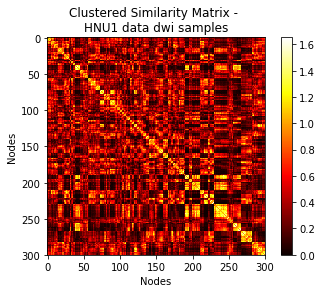

In [77]:
#create a heat map of the sorted similarity matrix
plt.figure(1)
im = plt.imshow(sortedSimMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.title("Clustered Similarity Matrix - \nHNU1 data dwi samples")
plt.show()

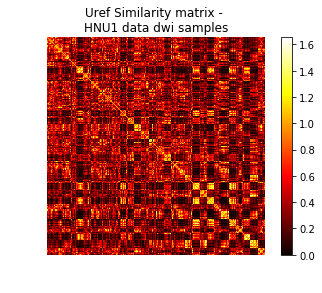

In [78]:
#create a heat map of the Urerf Similarity Matrix
plt.figure(2)
im = plt.imshow(inputMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Graphs')
plt.ylabel('Graphs')
plt.title("Uref Similarity matrix - \nHNU1 data dwi samples")
plt.axis('off')
plt.show()

In [79]:
###### Create a plot of the clusters color-coded as such ######
from sklearn.metrics import accuracy_score
print('AFFINITY PROPAGATION')
if (numFeatures ==2):
    graph2DLabels(mat,labels_best_af)
if (numFeatures ==3):
    graph3DLabels(mat,labels_best_af)
print("Number of Clusters = ", n_clusters_af)
print("Accuracy", accuracy_score(labels_best_af, correctLabels))

AFFINITY PROPAGATION
Number of Clusters =  84
Accuracy 0.0266666666667


In [80]:
###### Create a plot of the clusters color-coded as such ######
print('MINI BATCH K MEANS')
if (numFeatures ==2):
    graph2DLabels(mat,labels_best_mb)

if (numFeatures ==3):
    graph3DLabels(mat,labels_best_mb)
print("Number of Clusters = ", n_clusters_mb)
print("Accuracy", accuracy_score(labels_best_mb, correctLabels))

MINI BATCH K MEANS
Number of Clusters =  30
Accuracy 0.0433333333333


In [81]:
##### Compare the two Algorithms #####
print("Accuracy", accuracy_score(labels_best_mb, labels_best_af))
print(labels_best_af)
print(labels_best_mb)

Accuracy 0.0
[ 1  0 17  0  0  1 52 65  0  1 19  1  3  2  2  4 70 80  3  4  6 81 37 19 73
  5 54 19  6  6 25 20  7  8 70  0  9 10 20  0 70 11 75 12 12 12 71 12 12 12
 13 15 14 15 14 13 15 70 16 15 17 65 17 18  9 19 19 19 18 18 20 21 42 23 22
 23 10 23 30 24 42 57 28 26 25 25 26 27 28 28 31 35 29  9 81 30 31  4 17 49
 52 32 60 13 33 70 34 34 34 57 35 36 12 36 51 76 36 48 40 50 20 37 37 82 82
 42 81 37 82 25 40 38 38 39 14 40 18 41 18 35 42 43 43 43 57 20 43 24 44 74
 66 45 46 41 66 47 18 49 48 49 48 47 47 51 45 45 51 50 50 51 52  2 53 56 54
 61 55 56 54  2  5  6  5 57 20 57 57 58 78 25 79 79 59 21 45  7 77 45 49 45
 83 60 71 60 71 63 63 71 71 70 79 56 61 67 77 67 56 61 77 67 63 62 62 60 63
 60 63 63 63 71 81 64 61  2 55 65 26 65 65 82 66 66 49 67 68 69 69 66 53 69
 70 60 71 70 71  3 71 62  3 71 73 29 72 73 25 74 25 82 73 72 51 76 75 75 75
 76 76 75 75 76 77 77 77 53 78 77 79 79 68 79  3 80 80 83 81 82 83 31 83 30]
[14 14 14 14 14 14 14 14 14 14 18 27 18 25 18 18 18 18 18 18  9  9  9  9  